In [2]:
import np as np
import pandas as pd

In [3]:
df_train = pd.read_csv("./../data/train.csv").dropna()
df_test_nolabel = pd.read_csv("./../data/test_nolabel.csv").dropna()
df_sample_submission = pd.read_csv("./../data/sample_submission.csv").dropna()

/var/folders/9r/sd92rccj2_xbk8nkg4v7dcm00000gn/T/ipykernel_41413/1399654736.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("./../data/train.csv").dropna()


In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
    FunctionTransformer


def to_lowercase(df):
    """
    set all strings to lower case to be easier to group
    """
    df_return = df.apply(lambda col: col.str.lower())
    return df_return

def limit_outlier(df, max_value):
    """
    clamps the max and min value of a series, for prevent outliers
    from destroying statistic values
    """
    df_return = df.clip(0, max_value)
    return df_return

def fix_new_exists(df):
    """
    fixes newExists col to boolean values
    """
    df["NewExist"] = df["NewExist"].apply(lambda row: 1 if row in [0, 1] else 2)
    return df

def fix_franchise_code(df):
    """
    fixes FranchiseCode to {0, 1}
    """
    df["FranchiseCode"] = df["FranchiseCode"].apply(lambda row: 0 if row <= 1 else 1)
    return df

def fix_revlinecr(df):
    """
    fixes RevLineCr to {0, 1}
    """
    df["RevLineCr"] = df["RevLineCr"].apply(lambda row: 0 if row in ["N", 0] else 1)
    return df.astype(np.int64)

def fix_lowdoc(df):
    """
    fixes LowDoc to {0, 1}
    """
    df["LowDoc"] = df["LowDoc"].apply(lambda row: 1 if row in ["Y", "S"] else 0)
    return df.astype(np.int64)


def fix_disbursment_gross(df):
    """
    fixes disbursment extracting real value from string
    """
    df["DisbursementGross"] = df_train["DisbursementGross"]\
        .str.extract("(\d+(?:,\d+)*(?:\.\d+)?)")[0]\
        .str.replace(",", "")\
        .astype("float")
    return df

def fix_urban_rural(df):
    """
    fixes UrbanRural to {0, 1}
    """
    df_return = df[df["UrbanRural"] == 0]
    return df


training_numeric = ["NoEmp", "NewExist", "CreateJob", "FranchiseCode", "RevLineCr", "LowDoc", "DisbursementGross"]

preprocessor = ColumnTransformer(
    transformers=[
        # group 1 -> Set to lower and onehot with in freq 3
        ("group_a", Pipeline([
            ("a1", FunctionTransformer(to_lowercase)),
            ("a2", OneHotEncoder(handle_unknown='ignore', sparse=True, min_frequency=3))
        ]), ["Name"]),

        # group 2 -> Set to lower and onehot with in freq 300
        ("group_b", Pipeline([
            ("b1", FunctionTransformer(to_lowercase)),
            ("b2", OneHotEncoder(handle_unknown='ignore', sparse=True, min_frequency=300))
        ]), ["City", "Bank", "BankState"]),

        # group 3 -> clamps values [0, 155] and scales in standard dist
        # si se quiere cambiar por otras opciones crear una función como la de abajo...
        ("group_c", Pipeline([
            ("c1", FunctionTransformer(limit_outlier, kw_args={'max_value': 155})),
            ("c2", StandardScaler()),
        ]), ["NoEmp"]),

        # # group 4 -> sustituye {0, 1, 2} por {1, 2}
        ("group_d", Pipeline([
            ("d1", FunctionTransformer(fix_new_exists)),
            ("d2", SimpleImputer(strategy="most_frequent")),
        ]), ["NewExist"]),

        # group 5 -> clamps values [0, 1027] and scales in standard dist
        # si se quiere cambiar por otras opciones crear una función como la de abajo...
        ("group_e", Pipeline([
            ("e1", FunctionTransformer(limit_outlier, kw_args={'max_value': 1027})),
            ("e2", StandardScaler()),
        ]), ["CreateJob"]),

        # group 6 -> transforma la columna a bool
        ("group_f", Pipeline([
            ("f1", FunctionTransformer(fix_franchise_code)),
        ]), ["FranchiseCode"]),

        # group 7 -> transforma la columna a bool
        ("group_g", Pipeline([
            ("g1", FunctionTransformer(fix_revlinecr)),
        ]), ["RevLineCr"]),

        # group 8 -> transforma la columna a bool
        ("group_h", Pipeline([
            ("h1", FunctionTransformer(fix_lowdoc)),
        ]), ["LowDoc"]),

        # group 9 -> extrae el valor con un regex y lo escala
        ("group_i", Pipeline([
            ("i1", FunctionTransformer(fix_disbursment_gross)),
            ("d2", SimpleImputer(strategy="mean")),
            ("i2", StandardScaler()),
        ]), ["DisbursementGross"]),

        # group 10 -> transforma la columna a bool
        ("group_j", Pipeline([
            ("fj", FunctionTransformer(fix_urban_rural)),
        ]), ["UrbanRural"]),
    ],
)

preprocessor_label = LabelEncoder()
preprocessor.fit(df_train)
preprocessor_label.fit(df_train["Accept"])

TypeError: __init__() got an unexpected keyword argument 'min_frequency'

In [14]:
training_cols = ["Name", "City", "Bank", "BankState", "NoEmp", "NewExist", "CreateJob", "FranchiseCode", "RevLineCr", "LowDoc", "DisbursementGross"]

In [15]:
X_train = preprocessor.transform(df_train)
y_train = preprocessor_label.transform(df_train["Accept"])

In [20]:
X_train[0].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.93089489,
        0.        ]])

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=3)
model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [69]:
y_train_pred = model.predict(X_train)
print("Accuracy in training ", metrics.accuracy_score(y_train, y_train_pred))

Accuracy in training  0.8018445849683821


Accuracy in testing  0.5068669527896996


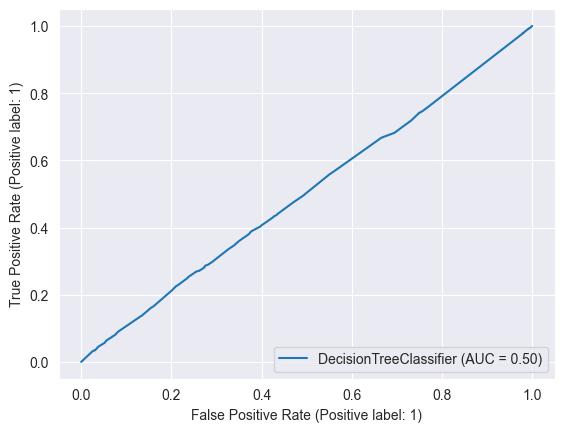

In [70]:
from sklearn.metrics import RocCurveDisplay

y_test_pred = model.predict(X_test)
print("Accuracy in testing ", metrics.accuracy_score(y_test, y_test_pred))
RocCurveDisplay.from_estimator(model, X_test, y_test)